In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Envs import register
import gymnasium as gym
from stable_baselines3 import PPO
from vis_model import aggregate_eval, plot_eval, plot_multiple_eval, plotly_vector_field, visualize_plotly_model
import plotly.express as px

pybullet build time: Oct  3 2024 08:55:45


In [2]:
model_path = "../checkpoints/StaticWaypointEnv/SingleWaypointNavigation/FixVel+AzimuthAlignPow2/best_model"
env_id = "SingleWaypointQuadXEnv-v0"

render = False
num_eval_eps = 1
env = gym.make(env_id, render_mode="human" if render else None)
_ = env.reset()
model = PPO.load(model_path, deterministic=True)

In [16]:
result = aggregate_eval(model, env, num_eval_eps, render=False, include_waypoints=True)

# Visualizing Trajectory and Waypoints

In [17]:
# Visualizing 'n_eval_eps' episodes as sampled from the trained model
visualize_plotly_model(result, model, env, num_eval_eps)

# Trajectory with vector field

In [19]:
ep_idx = 0
linear_positions = result["linear_position"][ep_idx]
linear_velocities = result["linear_velocity"][ep_idx]
target_vector = result["waypoints"][ep_idx]
plotly_vector_field(linear_positions, linear_velocities, target_vector, size=0.5)

# Smoothness of control inputs

/Users/felixunterleiter/Documents/GitHub/pyflyt_experience/Evaluation/vis_model.py:126: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



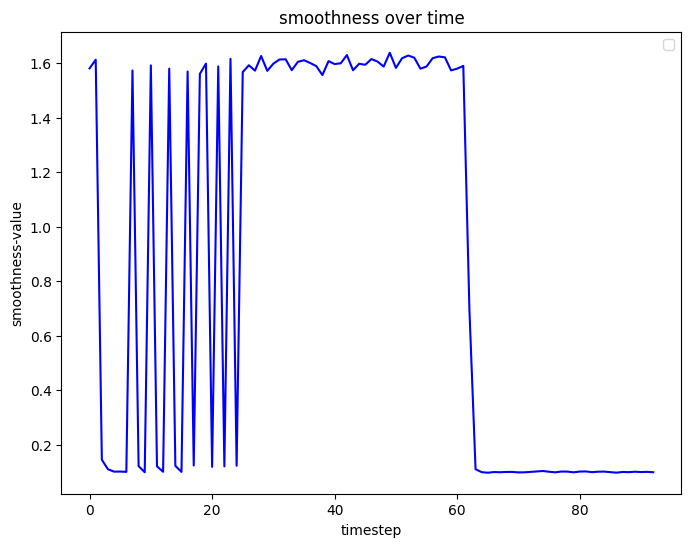

In [5]:
smoothness_result = {
    "smoothness": result["smoothness"]
}
plot_eval(smoothness_result, average=False)

# Azimuth and Elevation Angles

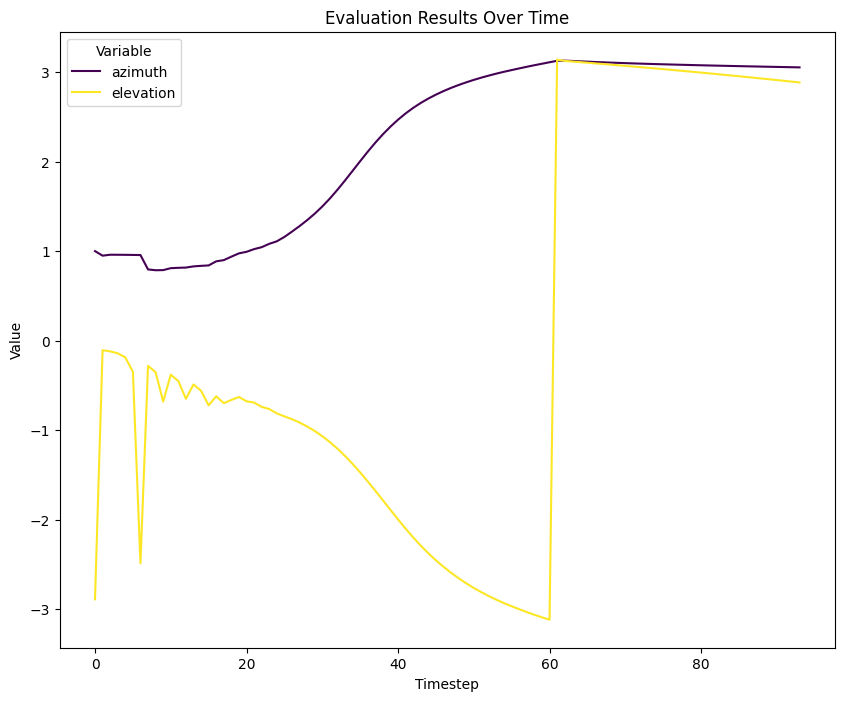

In [6]:
angles_result = {
    "azimuth": result["azimuth_angle"],
    "elevation": result["elevation_angle"]
}

plot_multiple_eval(angles_result, average=False)

# Angular Positions over time

In [11]:
abs_max_pitch, abs_max_roll, abs_max_yaw = -np.inf, -np.inf, -np.inf
abs_min_pitch, abs_min_roll, abs_min_yaw = np.inf, np.inf, np.inf

for ep in result["angular_position"]:
    # Plot the maximum angular position for each episode
    max_pitch, max_roll, max_yaw = np.max(np.abs(ep), axis=0)
    min_pitch, min_roll, min_yaw = np.min(np.abs(ep), axis=0)
    if max_pitch > abs_max_pitch:
        abs_max_pitch = max_pitch
    if max_roll > abs_max_roll:
        abs_max_roll = max_roll
    if max_yaw > abs_max_yaw:
        abs_max_yaw = max_yaw
        
    if min_pitch < abs_min_pitch:
        abs_min_pitch = min_pitch
    if min_roll < abs_min_roll:
        abs_min_roll = min_roll
    if min_yaw < abs_min_yaw:
        abs_min_yaw = min_yaw
    
print(f"Max Pitch: {abs_max_pitch}, Max Roll: {abs_max_roll}, Max Yaw: {abs_max_yaw}")
print(f"Min Pitch: {abs_min_pitch}, Min Roll: {abs_min_roll}, Min Yaw: {abs_min_yaw}")

Max Pitch: 2.2960142838117537, Max Roll: 0.8685464801449481, Max Yaw: 2.53209185471233
Min Pitch: 0.00011649151951028298, Min Roll: 4.4296953716315676e-05, Min Yaw: 0.0001727092047476022


# Experimentation

In [2]:
env_id = "SingleWaypointQuadXEnv-v0"
env = gym.make(env_id, render_mode=None)

term, trunc = False, False
obs, info = env.reset()
target_vector = env.unwrapped.waypoints.targets[0]
print(f'Target vector: {target_vector}')

linear_positions = []
linear_velocities = []  # in unit-length
t = 0
sign = 1

while not (term or trunc):
    action = np.array([0.2*np.pi, 0.0*np.pi, 0.0*np.pi, 0.7])
    obs, reward, term, trunc, info = env.step(action)
    linear_positions.append(info["linear_position"])
    # linear_velocities.append(info["linear_velocity"]/np.linalg.norm(info["linear_velocity"]))
    lin_vel = info["linear_velocity"]
    # lin_vel[2] = 0.0
    linear_velocities.append(lin_vel)
    lin_vel_xy_proj = info["linear_velocity"][:2]/np.linalg.norm(info["linear_velocity"][:2])
    LOS_vector = target_vector - info["linear_position"]
    LOS_xy_proj = LOS_vector[:2]/np.linalg.norm(LOS_vector[:2])
    print(f'(t={t}): velocity: {lin_vel_xy_proj}; LOS: {LOS_xy_proj}; azimuth: {obs["azimuth_angle"]}; elevation: {obs["elevation_angle"]}')
    # print(f'(t={t}): Current angular position: {info["angular_position"]}')
    # print(f'(t={t}): Current angular velocity: {obs["ang_vel"]}')
    # if np.abs(info["angular_position"][0]) >= 1.0*np.pi:
    #     print("---- Angular position exceeded threshold ----")
    #     sign *= -1
    t += 1

                             
                             
Target vector: [ 3.70544838 -5.08513615 15.        ]
(t=0): velocity: [ 0.49074018 -0.87130596]; LOS: [ 0.58891703 -0.8081935 ]; azimuth: [-0.11677914]; elevation: [-2.77881031]
(t=1): velocity: [ 0.32509583 -0.94568108]; LOS: [ 0.58894076 -0.80817621]; azimuth: [-0.2986345]; elevation: [0.33642256]
(t=2): velocity: [ 0.4422331  -0.89690015]; LOS: [ 0.58899373 -0.80813761]; azimuth: [-0.17172615]; elevation: [0.33032423]
(t=3): velocity: [ 0.50437163 -0.86348669]; LOS: [ 0.58905941 -0.80808973]; azimuth: [-0.10124029]; elevation: [0.32343689]
(t=4): velocity: [ 0.52521545 -0.85096929]; LOS: [ 0.58914034 -0.80803073]; azimuth: [-0.07702626]; elevation: [0.31735219]
(t=5): velocity: [ 0.52683993 -0.84996452]; LOS: [ 0.58924842 -0.80795191]; azimuth: [-0.07524993]; elevation: [0.31392479]
(t=6): velocity: [ 0.52538426 -0.85086507]; LOS: [ 0.58940388 -0.80783851]; azimuth: [-0.07715406]; elevation: [0.31250012]
(t=7): velocity: [ 

In [72]:
data = [{'X': pos[0], 'Y': pos[1], 'Z': pos[2]} for pos in linear_positions]
df = pd.DataFrame(data)

# Append the target vector to ensure it's considered in the range calculation
target_df = pd.DataFrame([{'X': target_vector[0], 'Y': target_vector[1], 'Z': target_vector[2]}])
df_with_target = pd.concat([df, target_df], ignore_index=True)

# Calculating the range for each axis for consistent scale
x_range = df_with_target['X'].max() - df_with_target['X'].min()
y_range = df_with_target['Y'].max() - df_with_target['Y'].min()
z_range = df_with_target['Z'].max() - df_with_target['Z'].min()
max_range = max(x_range, y_range, z_range) / 2

x_mid = (df_with_target['X'].max() + df_with_target['X'].min()) / 2
y_mid = (df_with_target['Y'].max() + df_with_target['Y'].min()) / 2
z_mid = (df_with_target['Z'].max() + df_with_target['Z'].min()) / 2

# Create a color list with the first element white, rest red
colors = ['white'] + ['red'] * (len(df) - 1)

# Generate hover text for each point showing the index and coordinates
hover_text = ['Timestep: {}<br>X: {:.2f}<br>Y: {:.2f}<br>Z: {:.2f}'.format(i, df.iloc[i]['X'], df.iloc[i]['Y'], df.iloc[i]['Z'])
              for i in range(len(df))]

# Create the figure object with individual points
fig = go.Figure(data=[go.Scatter3d(
    x=df['X'],
    y=df['Y'],
    z=df['Z'],
    mode='markers',
    marker=dict(
        size=1,
        color=colors,  # Applying the color array to the points
        opacity=1
    ),
    text=hover_text,  # Assign hover text to each point
    hoverinfo='text'
)])

# Adding the target vector as a waypoint
fig.add_trace(go.Scatter3d(
    x=[target_vector[0]],
    y=[target_vector[1]],
    z=[target_vector[2]],
    mode='markers',
    marker=dict(
        size=10,  # Bigger size for visibility
        color='blue'
    ),
    name='Target'  # Label for hover
))

# Setting equal aspect ratio manually and adjusting ranges
fig.update_layout(scene=dict(
    xaxis=dict(range=[x_mid - max_range, x_mid + max_range]),
    yaxis=dict(range=[y_mid - max_range, y_mid + max_range]),
    zaxis=dict(range=[z_mid - max_range, z_mid + max_range]),
    aspectmode='manual'
))

fig.update_layout(title='Trajectory of Single Episode')

fig.show()